In [159]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [47]:
# generate data

dataPoints = 2000
data = np.zeros((dataPoints, 2))
labels = np.zeros((dataPoints, 1))

for i in range(dataPoints):
    data[i][0] = np.random.randint(-10, 11)
    data[i][1] = np.random.randint(-10, 11)
    labels[i][0] = data[i][0] + data[i][1]

In [48]:
data[0]

array([ 2., -9.])

In [49]:
dataT = torch.Tensor(data)
labelsT = torch.Tensor(labels)

In [54]:
# split into dev, devset and test

partition = [0.8, 0.1, 0.1]

train_data, testTMP_data, train_labels, testTMP_labels = train_test_split(dataT, labelsT, train_size=partition[0])

split = partition[1]/sum(partition[1:])

devset_data, test_data, devset_labels, test_labels = train_test_split(testTMP_data, testTMP_labels, train_size=split)

In [55]:
train_labels.shape

torch.Size([1600, 1])

In [56]:
train_dataT = TensorDataset(train_data, train_labels)
devset_dataT = TensorDataset(devset_data, devset_labels)
test_dataT = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataT, batch_size=32, shuffle=True, drop_last=True)
devset_loader = DataLoader(devset_dataT, batch_size=devset_dataT.tensors[0].shape[0])
test_loader = DataLoader(test_dataT, batch_size=test_dataT.tensors[0].shape[0])

In [137]:
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)

        return x



In [133]:
def getModel():

    ANN = model()
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [134]:
epochs = 200

def trainModel(ANN, lossFunction, optimizer):

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)

            loss = lossFunction(yHat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.round(yHat) == y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(devset_loader))
        with torch.no_grad():
            pred = ANN(X)
        
        testAcc.append(torch.mean((torch.round(pred) == Y).float())*100)

    return trainAcc, testAcc, losses
    


In [155]:
for i in range(10):
    ANN, lossFunction, optimizer = getModel()
    trainAcc, testAcc, losses = trainModel(ANN, lossFunction, optimizer)
    print('Model instance %s, final train/devset accuracy: %g%%, %g%%' %(i, trainAcc[-1], testAcc[-1]))

Model instance 0, final train/devset accuracy: 100%, 97.5%
Model instance 1, final train/devset accuracy: 100%, 100%
Model instance 2, final train/devset accuracy: 99.9375%, 100%
Model instance 3, final train/devset accuracy: 99.25%, 100%
Model instance 4, final train/devset accuracy: 88.8125%, 85%
Model instance 5, final train/devset accuracy: 99.6875%, 100%
Model instance 6, final train/devset accuracy: 100%, 100%
Model instance 7, final train/devset accuracy: 100%, 100%
Model instance 8, final train/devset accuracy: 100%, 100%
Model instance 9, final train/devset accuracy: 100%, 100%


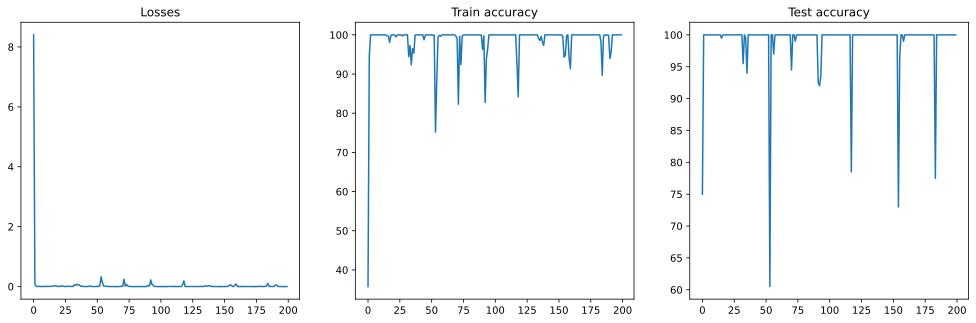

In [156]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(losses)
ax[0].set_title('Losses')

ax[1].plot(trainAcc)
ax[1].set_title('Train accuracy')

ax[2].plot(testAcc)
ax[2].set_title('Test accuracy')

plt.show()

In [157]:
X, Y = next(iter(test_loader))
pred = ANN(X)
finalAcc = torch.mean((torch.round(pred) == Y).float())*100
finalAcc

tensor(100.)

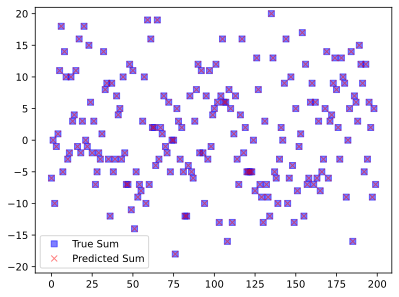

In [158]:
plt.plot(Y, 'bs', label='True Sum',alpha=.5)
plt.plot(pred.detach().numpy(), 'rx', label='Predicted Sum',alpha=.5)
plt.ylim([-21, 21])
plt.legend()
plt.show()